The goal of this notebook is to distill down the essential compenents of training HF models in a way that is easy to port to a data pipeline and apply to new model training scenarios.

# Imports

In [1]:
import os
import pandas as pd
from rich import print
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datetime import datetime;
pd.set_option('display.max_colwidth', None)

# Define variables

In [2]:
if True:
    date_str = datetime.now().strftime("%Y_%m_%d")
date_str

'2023_11_12'

In [3]:
work_dir = "work"
seed = 42 #reproducability  over training runs
clobber_project_dir = False #wipe the project director clean
project_dir = f"work_for_{date_str}" #project name, also used as wandb project name

#creds
hf_token = os.environ["HF_TOKEN"]
wandb_key = os.environ["WANDB_KEY"]
hf_account_name = os.environ["HF_ACCOUNT_NAME"]

#HF touchpoints
hf_dataset_name = "knkarthick/dialogsum"
source_hf_model_name = "meta-llama/Llama-2-7b-hf"

checkpoint_dir = "best_checkpoint"
quantization_dir = 'quantized_8bit'
merged_dir = 'merged_model'
quantized_train_dir = 'quant_trained_model_new'

train_test_split_ratio = 0.05

#LoRA hparams
lora_r = 64  # rank
lora_alpha = lora_r * 2
lora_dropout = 0.05

#training hparams
epochs = 1
max_steps = 100
per_device_train_batch_size=1
gradient_accumulation_steps=1
early_stopping_patience = 3
learning_rate = 1e-4
logging_steps = 25
device = "cuda"
max_seq_length = 512
#quantization params
quantization_bits = 4

destination_hf_model_name = f"{hf_account_name}/llama2-7b-dialogsum-qlora-gptq"
project_path = os.path.join(work_dir,project_dir, checkpoint_dir)
quant_path = os.path.join(project_dir, quantization_dir)
quantized_train_path = os.path.join(project_dir, quantized_train_dir)
merged_path = os.path.join(project_path, merged_dir)

project_path

'work/work_for_2023_11_12/best_checkpoint'

## State of working directory

In [4]:
print(project_dir)
!mkdir -p $project_dir

#Set clobber_project_dir to True to reset working directory
if clobber_project_dir:
    !rm -rf ./$project_dir

!mkdir -p $project_dir

!ls -latrs ./$project_dir

work_for_2023_11_12

total 0
0 drwxr-xr-x 1 root root 4096 Nov 12 02:30 quant_trained_model_new
0 drwxr-xr-x 1 root root 4096 Nov 12 02:30 .
0 drwxr-xr-x 1 root root 4096 Nov 12 03:07 ..


## Initiate wandb

In [5]:
import wandb

wandb.login(key = wandb_key)
run = wandb.init(project=project_dir, job_type="training", anonymous="allow")

wandb: Currently logged in as: jason-anderson-professional. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Process data for training

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator




def analyze_generation_params(text, model):
    print(text,"-"*60)
    results = []
    for temp in np.linspace(.5,1.5,num = 5):
        print(f"temp {temp}:",end="")
        results.append(generate(text, model, prompt=False, max_new_tokens=185,temp=temp))
    
    print("-"*60)
    results = []
    for top_p in np.linspace(0,1,num = 11):
        print(f"top_p {top_p}:",end="")
        results.append(generate(text, model, prompt=False, max_new_tokens=185,temp=.7, top_p=top_p))
    
    
    print("-"*60)
    results = []
    for top_k in np.linspace(0,100,num = 11,dtype=int):
        print(f"top_k {top_k}:",end="")
        results.append(generate(text,  model, prompt=False, max_new_tokens=185, top_k=int(top_k)))
    
    print("-"*60)
    results = []
    for do_sample in [True,False]:
        print(f"do_sample {do_sample}:",end="")
        results.append(generate(text,  model, prompt=False, max_new_tokens=185, do_sample = do_sample, top_k=None))
    
    
    print("-"*60)
    results = []
    for repetition_penalty in np.linspace(1.,2.,num=11):
        print(f"repetition_penalty {repetition_penalty}:",end="")
        results.append(generate(text,  model, prompt=False, max_new_tokens=48,repetition_penalty=repetition_penalty))
    
    print("-"*60)
    results = []
    for typical_p in np.linspace(.1,.9,num=9):
        print(f"typical_p {typical_p}:",end="")
        results.append(generate(text,  model, prompt=False, max_new_tokens=48,typical_p=typical_p))


def generate(text, model, prompt=False, temp=0.7,top_k= 40, top_p = 0.1, do_sample = True, repetition_penalty = 1.23, typical_p = 1, guidance_scale = 1, max_new_tokens = 24,):
    from transformers import TextStreamer
    if prompt:
        print(text,"-"*20)
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=False)
    inputs = tokenizer(text, return_tensors="pt").to('cuda')

    # Call the generate method of the model with the given inputs and additional generation configurations.
    outputs = model.generate(**inputs,  # "inputs" likely includes input_ids or prompts for generation.
                           streamer=streamer,  # "streamer" not a standard parameter in HF documentation, likely custom for model-specific streaming.
                           max_new_tokens=max_new_tokens,  # Sets the maximum number of new tokens to generate; range varies based on model and computational limits.
                           temperature=temp,  # Controls randomness: lower->more deterministic, higher->more random; typically in range [0.5, 1.5].
                           do_sample=do_sample,  # Enables sampling; when True, picks tokens based on probability distribution, rather than just most likely.
                           top_p=top_p,  # Nucleus sampling: selects top p% probability tokens for sampling; range [0, 1].
                           top_k=top_k,  # Top-k sampling: chooses from top k probability tokens; if k=0, it's the same as using no top-k.
                           repetition_penalty=repetition_penalty,  # Penalizes repeated tokens; >1 discourages, <1 encourages repetition; typically close to 1.
                           typical_p=typical_p,  # Typical sampling; selects tokens whose cumulative probability is above this threshold, range [0, 1], usually close to 1.
                           guidance_scale=guidance_scale,  # Affects the scale of guidance in models that support it, like CTRL; standard range not well-defined.
                           #seed=seed,  # Sets a seed for reproducibility; commented out, so not in use.
                          )
    generated_tokens = outputs[0].tolist()[len(inputs[0]):]
    result = tokenizer.decode(generated_tokens)
    return result

def set_plot_appearance(fontsize_title=14, 
                        fontsize_label=12, 
                        fontsize_ticks=8, 
                        theme='dark'):
    """
    Configure the plot's appearance with font sizes and theme for dark backgrounds.
    
    Parameters:
    fontsize_title: Font size for the title.
    fontsize_label: Font size for the x and y labels.
    fontsize_ticks: Font size for the x and y tick labels.
    theme: Seaborn theme for the plot's aesthetic style.
    """
    sns.set_theme(style=theme, palette='pastel')
    
    plt.rcParams.update({
        'figure.facecolor': '#1a1a1a',  # Very dark grey background for the figure
        'axes.facecolor': '#1a1a1a',    # Very dark grey background for the plots
        'grid.color': 'gray',           # Lighter grey grid lines (less contrast)
        'text.color': 'white',          # White text for better contrast on dark bg
        'axes.labelcolor': 'white',     # White labels for axes
        'xtick.color': 'white',         # White x-tick labels
        'ytick.color': 'white',         # White y-tick labels
        'axes.labelsize': fontsize_label,
        'axes.titlesize': fontsize_title,
        'xtick.labelsize': fontsize_ticks,
        'ytick.labelsize': fontsize_ticks,
        'legend.title_fontsize': fontsize_ticks + 2,
        'legend.fontsize': fontsize_ticks,
        'axes.edgecolor': 'lightgrey',  # Light grey color for the axes' spines
    })
# Possible modern themes: 'darkgrid', 'whitegrid', 'dark', 'white', and 'ticks'.
# Example usage: set_plot_appearance(theme='ticks')

def plot_text_length_histogram(df, bucket_size=64, percentile=95):
    """
    Plot a histogram of text lengths and indicate the percentile.

    Parameters:
    df: the pandas dataframe to render from
    bucket_size: the number of characters to bucket the histogram with
    percentile: draws a vertical line at this percentile to visualize whether an acceptable fraction of the data lenghts are being used for training set
    """
    set_plot_appearance()  # Apply appearance settings to the plot
    text_lengths = df['text'].apply(len)  # Calculate text lengths.
    bins = range(0, max(text_lengths) + bucket_size, bucket_size)  # Define histogram bins.
    percentile_value = np.percentile(text_lengths, percentile)  # Calculate percentile value.

    fig, ax = plt.subplots()  # Create figure and axis objects.
    ax.hist(text_lengths, bins=bins, edgecolor='black', alpha=0.7)  # Plot histogram.
    ax.axvline(x=percentile_value, color='red', linestyle='--')  # Draw percentile line.
    
    # Annotate the percentile line.
    ax.text(percentile_value, ax.get_ylim()[1]*0.9, f' {percentile}th Percentile: {int(round(percentile_value, -1))}',
            color='red', ha='left')

    ax.set_xlabel('Text Length')  # Set x-axis label.
    ax.set_ylabel('Frequency')  # Set y-axis label.
    ax.set_title('Histogram of Text Lengths')  # Set title.

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Set major locator for x-axis.
    plt.show()  # Display the plot.

def visualize_train_test_category_splits(train_df, test_df, top_x=5, normalize=True):
    """
    Visualize the frequency of top categories in training and test datasets.
    """
    set_plot_appearance()  # Apply appearance settings to the plot

    # Get top x categories from both datasets.
    train_topic_norm = train_df['topic'].value_counts(normalize=normalize).head(top_x)
    test_topic_norm = test_df['topic'].value_counts(normalize=normalize).head(top_x)
    
    # Prepare the data for plotting.
    train_topics = pd.DataFrame({'topic': train_topic_norm.index, 'frequency': train_topic_norm.values, 'dataset': 'Training'})
    test_topics = pd.DataFrame({'topic': test_topic_norm.index, 'frequency': test_topic_norm.values, 'dataset': 'Test'})
    combined_topics = pd.concat([train_topics, test_topics])

    sns.barplot(x='frequency', y='topic', hue='dataset', data=combined_topics)  # Create bar plot.
    plt.title('Top {} Topics Frequency Comparison'.format(top_x))  # Set title.
    plt.xlabel('Normalized Frequency')  # Set x-axis label.
    plt.ylabel('Topic')  # Set y-axis label.
    plt.tight_layout()  # Adjust layout.
    plt.show()  # Display the plot.



def get_data_stuff(dataset_name, split_ratio=0.2):    
    # %%
    from datasets import load_dataset
    from datasets import Dataset
    import pandas as pd
    pd.set_option('display.max_colwidth', None)
    
    
    #load the dataset
    dataset = load_dataset(dataset_name)
    
    # Shuffle the dataset (setting seed for reproducibility)
    shuffled_ds = dataset['train']#.shuffle(seed=seed)
    #shuffled_ds = shuffled_ds.select(range(1000))

    
    # Split the dataset into training and test sets with a test size of 20%
    train_test_split = shuffled_ds.train_test_split(test_size=train_test_split_ratio, seed = seed)
    
    # The train/test datasets are now accessible as follows:
    train_ds = train_test_split['train']
    raw_train_df = pd.DataFrame(train_ds)
    
    test_ds = train_test_split['test']
    raw_test_df = pd.DataFrame(test_ds)
    
    prepared_train_df = prepare_dataset(raw_train_df, "train")
    prepared_test_df = prepare_dataset(raw_test_df, "test")

    prepared_train_dataset = Dataset.from_pandas(prepared_train_df)
    prepared_test_dataset = Dataset.from_pandas(prepared_test_df)
    
    print(f"length of downloaded ds: {len(shuffled_ds)}")
    print(f"length of train_ds: {len(prepared_train_dataset)}")
    print(f"length of test_ds: {len(prepared_test_dataset)}")
    estimated_training_steps = epochs * len(prepared_train_dataset) / per_device_train_batch_size / gradient_accumulation_steps
    print(f"estimated training steps will be {estimated_training_steps}")
    return prepared_train_df, prepared_test_df, prepared_train_dataset, prepared_test_dataset


def prepare_dataset(df, split="train"):
    text_col = []
    instruction = """Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only provide full sentence responses."""  # change instuction according to the task
    if split == "train":
        for _, row in df.iterrows():
            input_q = row["dialogue"]
            output = row["summary"]
            text = (
                "### Instruction: \n"
                + instruction
                + "\n### Input: \n"
                + input_q
                + "\n### Response :\n"
                + output
                + "\n### End"
            )  # keeping output column in training dataset
            text_col.append(text)
        df.loc[:, "text"] = text_col
    else:
        for _, row in df.iterrows():
            input_q = row["dialogue"]
            text = (
                "### Instruction: \n"
                + instruction
                + "\n### Input: \n"
                + input_q
                + "\n### Response :\n"
            )  # not keeping output column in test dataset
            text_col.append(text)
        df.loc[:, "text"] = text_col
    return df



In [7]:
train_df, test_df, train_dataset, test_dataset = get_data_stuff(hf_dataset_name, 
                                                                split_ratio=train_test_split_ratio,
                                                               )
text = test_df['text'][1]

length of downloaded ds: 12460

length of train_ds: 11837

length of test_ds: 623

estimated training steps will be 11837.0

In [8]:
print(text)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :

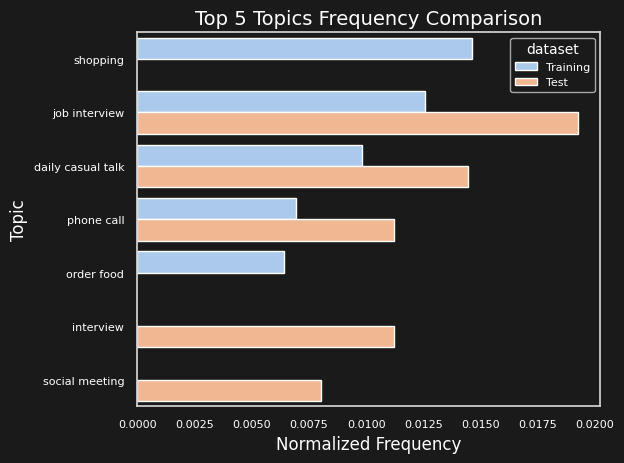

In [9]:
#to enhance training, consider rolling the shuffle dice until you get good consistency between training and test set categories.
visualize_train_test_category_splits(train_df, test_df, top_x=5, normalize=True)

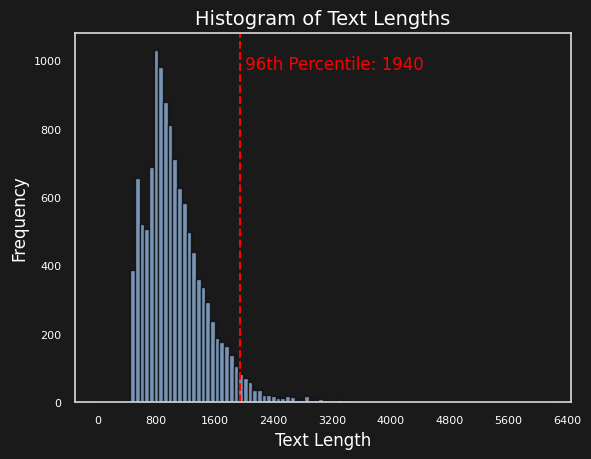

In [10]:
#this just measures space-delimited words which isn't necessarily the same as toke count, but it should be close-ish
plot_text_length_histogram(train_df, percentile = 96)

# Train from a previously qptq-quantized model

In [11]:
from transformers import EarlyStoppingCallback


import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model
from peft import prepare_model_for_kbit_training
from transformers import GPTQConfig
from transformers import Trainer, TrainingArguments #, DataCollatorForLanguageModeling
from trl import SFTTrainer

quant_model_id = "TheBloke/Llama-2-7B-GPTQ"

tokenizer = AutoTokenizer.from_pretrained(quant_model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


quantization_config_loading = GPTQConfig(bits=4, 
                                         disable_exllama=True,
                                        )
config = LoraConfig(
                            r=16,
                            lora_alpha=32,
                            target_modules=["k_proj","o_proj","q_proj","v_proj"],
                            lora_dropout=0.05,
                            bias="none",
                            task_type="CAUSAL_LM"
                        )
training_args=TrainingArguments(
                                per_device_train_batch_size=4, # Batch size per device during training
                                gradient_accumulation_steps=4, # Number of steps to accumulate gradients before updating model parameters
                                warmup_steps=2, # Number of steps for the warm-up phase
                                max_steps=max_steps, # Total number of training steps to perform
                                learning_rate=2e-4, # Initial learning rate
                                fp16=True, # Enable mixed precision training to improve performance
                                logging_steps=25, # Frequency of logging training information
                                output_dir=quantized_train_path, # Directory for saving output (like model checkpoints)
                                optim="adamw_hf", # Optimizer to be used for training, here it's a variant of AdamW from Hugging Face
                                save_strategy="steps", # Strategy for saving model checkpoints (here, at the end of each epoch)
                                report_to="none", # Disable reporting to any external services
                                evaluation_strategy="steps",  # Add this line
                                eval_steps=logging_steps,  # Add this line
                                metric_for_best_model="loss",
                                greater_is_better=False,
                                load_best_model_at_end=True,
                            )


quant_model = AutoModelForCausalLM.from_pretrained(quant_model_id, 
                                             quantization_config=quantization_config_loading, 
                                             device_map="auto",
                                            )


quant_model.config.use_cache = False
quant_model.config.pretraining_tp = 1
quant_model.gradient_checkpointing_enable()

prepared_model = prepare_model_for_kbit_training(quant_model)
peft_model = get_peft_model(prepared_model, config)
peft_model.print_trainable_parameters()
peft_model.config.use_cache = False # silence the warnings. Please re-enable for inference!

trainer = SFTTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
        eval_dataset=test_dataset,
    #peft_config=lora_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    packing=False,
    max_seq_length=max_seq_length,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
)

train_result = trainer.train()
#Also I noticed that you pass a PeftModel to SFTTrainer together with a peft_config argument, this might lead to create a nested peft model which can lead to some bugs.


checkpoint_name ="final_checkpoints_gptqsummarizer_7b_peft"
output_dir = os.path.join(quantized_train_path, checkpoint_name)
trainer.model.save_pretrained(output_dir)
from peft import AutoPeftModelForCausalLM
# To perform inference on the test dataset example load the model from the checkpoint
persisted_model = AutoPeftModelForCausalLM.from_pretrained(
    output_dir,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="cuda",
)

print(output_dir)
!ls -latrhs $output_dir

/app/venv/lib/python3.10/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(
You passed `quantization_config` to `from_pretrained` but the model you're loading already has a `quantization_config` attribute and has already quantized weights. However, loading attributes (e.g. disable_exllama, use_cuda_fp16, max_input_length) will be overwritten with the one you passed to `from_pretrained`. The rest will be ignored.


trainable params: 16,777,216 || all params: 279,187,456 || trainable%: 6.009301506726721


Map:   0%|          | 0/11837 [00:00<?, ? examples/s]

Map:   0%|          | 0/623 [00:00<?, ? examples/s]

/app/venv/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/app/venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.365600,1.217867
50,1.124300,1.207811
75,1.130800,1.203843
100,1.108000,1.202743


work_for_2023_11_12/quant_trained_model_new/final_checkpoints_gptqsummarizer_7b_peft

total 65M
  0 drwxr-xr-x 1 root root 4.0K Nov 12 03:18 ..
  0 -rw-r--r-- 1 root root  525 Nov 12 03:18 README.md
65M -rw-r--r-- 1 root root  65M Nov 12 03:18 adapter_model.bin
  0 drwxr-xr-x 1 root root 4.0K Nov 12 03:18 .
  0 -rw-r--r-- 1 root root  475 Nov 12 03:18 adapter_config.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
text = test_df['text'][1]
print("="*30)
result = generate(text, persisted_model, max_new_tokens=80, temp=0.5)


==============================

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


In [13]:
# repitition_penalty really blows test_df['text'][1] out of the water...`

analyze_generation_params(text, persisted_model)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :
 ------------------------------------------------------------

temp 0.5:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


temp 0.75:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


temp 1.0:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


temp 1.25:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


temp 1.5:

Ms. Smith will meet Mr. Ewing in the conference center with #Person1#, who takes his car for traffic congestion. They both decide to take the subway instead.
### EndResponse ##
### InSummarizeTaskEnd ##
</s>


------------------------------------------------------------

top_p 0.0:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


top_p 0.1:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


top_p 0.2:

Ms. Smith will meet Mr. Ewing in the conference center with #Person1#, who takes his car for traffic congestion. They both decide to take the subway instead.
### EndResponse ##
### InSummarizeTaskEnd ##
</s>


top_p 0.30000000000000004:

Ms. Smith will join Mr. Ewing in showing up for the meeting at 4 pm today since they both plan to use public transportation due to traffic congestion.
### EndResponse #Person2#
### EndInput #Person1#</s>


top_p 0.4:

Ms. Smith will drive her own car while Mr. Brown takes the subway with #Person1#, who also plans to use it for convenience. They both want to get to the meeting place early so they won't miss anything important.
### EndResponse ##
### InSummarize:
Mr. Brown suggests driving his car instead of using public transportation since traffic may cause trouble in finding their destination. But Ms. Smith thinks she would rather take the train due to its convenience. So do they decide to travel by themselves or join each other.
### EndInSummarize
</s>


top_p 0.5:

Mrs. Wong asks Mr. Ewing what time they need to arrive for their meeting with some people from East York Branch Office in the Conference Center. They decide to take the subway since it will save time due to traffic jam caused by road constructions.
### EndResponse ?
### Include?
### Cover?</s>


top_p 0.6000000000000001:

Ms. Smith will meet Mr. Ewing in the meeting room for the conference. They both decide to use public transportation since they need to get ready early.
### End Response
### Finish the summary with one or two sentences covering all main ideas of this response.
### Only provide full sentence responses.</s>


top_p 0.7000000000000001:

Ms. Wong tells Mr. Lee she will get to the meeting place by train since it would take longer time for her to drive through traffic jams caused by road constructions. They decide they both ride trains so that one person could help another when lost in the new environment.
### EndResponse ?
### Conclusion:
Mr. Lee decides to join #Person1# riding an underground instead of driving his own car due to the traffic jam caused by road constructions.</s>


top_p 0.8:

Ms. Jones tells #Person1# she will take her car while Mr. Ewing asks for their arrival time. They decide they will travel by subway since it would save some traffic jam trouble in case there is one due to road works.
### EndResponse
### InConclusion:
Mr. Ewing has arranged an important meeting with his colleagues from other branches. He expects everyone arrive punctually so that all participants could have enough time to prepare themselves beforehand. Meanwhile, both Ms. Jones and Mr. Ewing plan to drive or ride trains instead of cars which might cause troubles during rush hours.
</s>


top_p 0.9:

Mary tells #Person2# she will join her in driving to the meeting place. Mary says they need to arrive early since some guests come by bus or train.
### End Response ##
### Personal Feedback:
Mary plans to drive with #Person2#, while #Person2# prefers taking public transportation due to traffic problems. They agree to meet each other first before heading for their destination.</s>


top_p 1.0:

Mike tells #Person1# they need to arrive early for an important meeting tomorrow. They will both drive their cars before taking any other transportation means due to traffic jams caused by road constructions.
### End Response ##
### Inserts:
Construction Transportation Roadways Transport Systems Underground Railroads Conferences</s>


------------------------------------------------------------

top_k 0:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


top_k 10:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


top_k 20:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


top_k 30:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


top_k 40:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic congestion due to road constructions.
### EndResponse #Person1# tells #Person2# how she plans to get to the conference center.
### EndInput
</s>


top_k 50:

Ms. Smith will join Mr. Ewing in showing up for the meeting with some colleagues from their East York Branch Office. They decide to travel by subway since they have heard traffic 

KeyboardInterrupt: 